# Metrics

**What do we need to build our short medium view on crypto space**

TODO:
- Vol + Skew 
- Make Futures Premia into a table 
    - Add Deribit as well
- Whales
    - Make the metrics under this more useful / easier to read
- Twitter/Reddit Metrics

Completed: 
- [✓] Exchange Inflow/Outflows
    - BTC, ETH, USDT
- [✓] NVT Fair Value
- [✓] Futures Premia
- [✓] Borrow rates
- [✓] Futures Open Interest
- [✓] Equity Markets
- [✓] SOPR

**Big Narratives**
- Coinbase IPO
- Environmental FUD -  Elon
- EIP 1559 July (Will it be like Coinbase IPO, buy rumour, sell the fact)
- Bitcoin ETF
- DOGE Shitcoin Mania
- DEFI
- US Taxes Due 17 May
- Institutional Buying
- USDT FUD
- Regulatory Crackdown - (Binance)
- China Crackdown

In [1]:
%%capture
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from datetime import datetime
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
import json
import requests
import numpy as np

# Glassnode

In [2]:
load_dotenv()
API_KEY = os.getenv("glassnode_api_key")
TWITTER_API_KEY = os.getenv("TWITTER_API_KEY")
TWITTER_SECRET = os.getenv("TWITTER_SECRET")

In [3]:
API_KEY = os.getenv("glassnode_api_key")

In [4]:
# make API request
res = requests.get('https://api.glassnode.com/v1/metrics/indicators/sopr',
    params={'a': 'BTC', 'api_key': API_KEY})

# convert to pandas dataframe
df = pd.read_json(res.text, convert_dates=['t'])

In [5]:
res = requests.get('https://api.glassnode.com/v2/metrics/endpoints',
    params={'api_key': API_KEY})

In [6]:
df = pd.read_json(res.text, convert_dates=['t'])

In [7]:
for idx,row in df.iterrows():
    if 'ssr' in row['path']:
        print(idx,row['path'],row['tier'])

179 /v1/metrics/indicators/ssr 2


In [8]:
def glassnode_request(symbol,metric,exchanges=None):
    
    params={'a': symbol,'api_key': API_KEY}
    
    if exchanges:
        params['category'] = 'Exchanges'
        df = pd.DataFrame()
        for exch in exchanges:
            params['e'] = exch
            res = requests.get(f'https://api.glassnode.com/v1/metrics/{metric}', params)
            exch_df = pd.read_json(res.text, convert_dates=['t'])
            exch_df.set_index('t',inplace=True)
            exch_df.rename(columns={'v':exch},inplace=True)
            
            if len(df)==0:
                df = exch_df
            else:
                df = pd.concat([df,exch_df],join='outer',axis='columns')
            
            
    else:
        res = requests.get(f'https://api.glassnode.com/v1/metrics/{metric}', params)
        df = pd.read_json(res.text, convert_dates=['t'])
        df.set_index('t',inplace=True)
    
    return df

In [9]:
def plot_two_axes(data,col1,col2,title):
    

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])


    # Add traces
    fig.add_trace(
        go.Scatter(x=data.index, y=data[col1],name=col1),
        secondary_y=False,
    )
    fig['layout']['yaxis2']['showgrid'] = False

    #Add traces
    fig.add_trace(
        go.Scatter(x=data.index, y=data[col2],name=col2),
        secondary_y=True,
    )

    # Add figure title
    fig.update_layout(
        title_text=f"{title}",height=500
    )

    fig.show()

In [10]:
metric = 'transactions/transfers_volume_exchanges_net'
symbol = 'BTC'
exchanges = ['binance','huobi','coinbase','kraken','aggregated']

exch_flows = glassnode_request(symbol,metric,exchanges)

In [11]:
metric = 'distribution/balance_exchanges'
exchanges = None

btc_exch_balances = glassnode_request('BTC',metric,exchanges)
eth_exch_balances = glassnode_request('ETH',metric,exchanges)
usdt_exch_balances = glassnode_request('USDT',metric,exchanges)

In [12]:
metric = 'market/price_usd'
exchanges = None

btc_price = glassnode_request('btc',metric,exchanges)
eth_price = glassnode_request('eth',metric,exchanges)

In [13]:
data = btc_exch_balances.tail(365).copy()
data.loc[data.index, 'price'] = 1

## BTC Exchange Balances

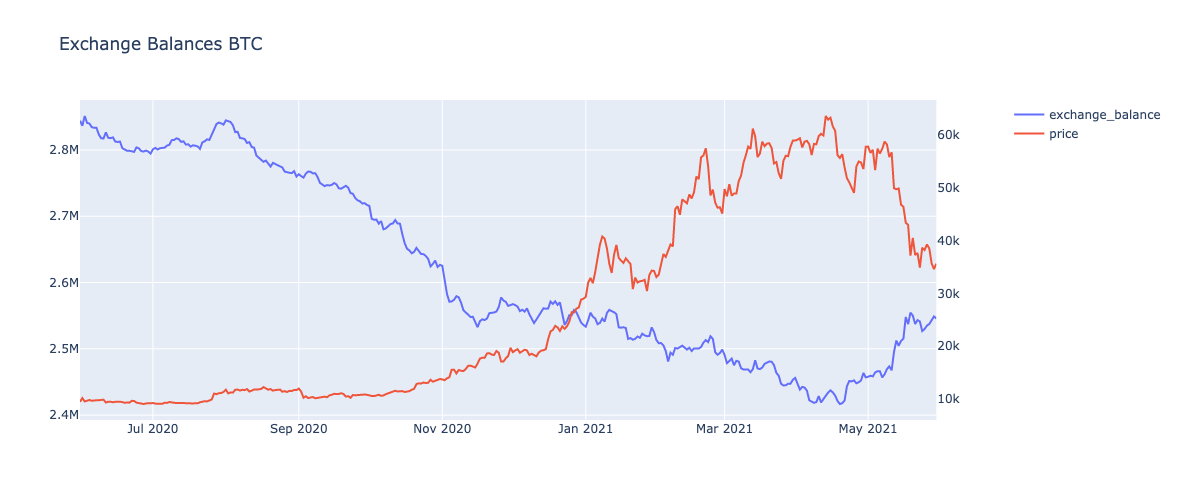

In [14]:
data.loc[data.index,'price'] = btc_price.loc[data.index, 'v']
data.rename(columns={'v':'exchange_balance'}, inplace=True)
plot_two_axes(data,'exchange_balance','price','Exchange Balances BTC')

## ETH Exchange Balances

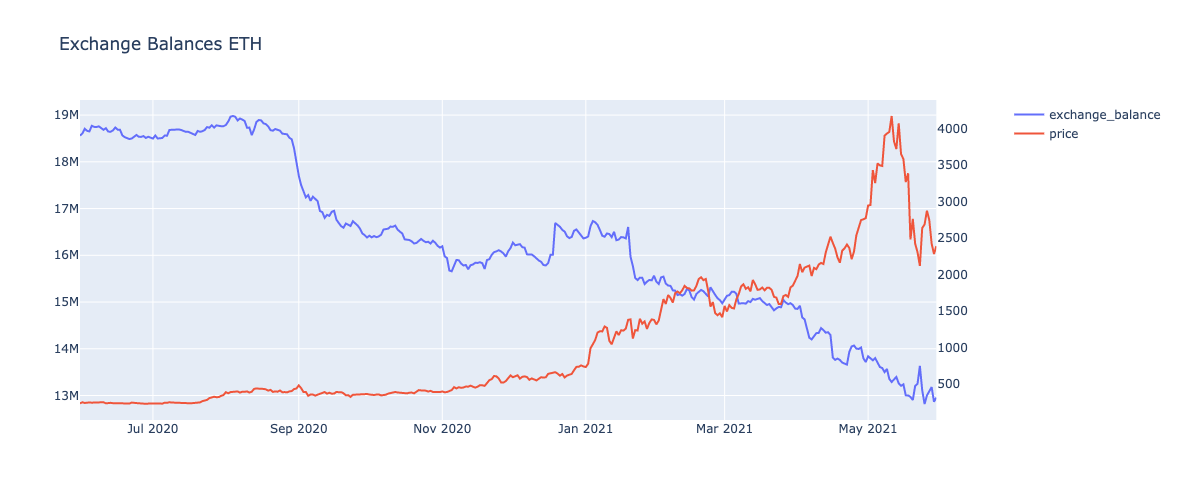

In [15]:
data = eth_exch_balances.tail(365).copy()
data.loc[data.index,'price'] = eth_price.loc[data.index,'v']
data.rename(columns={'v':'exchange_balance'},inplace=True)
plot_two_axes(data,'exchange_balance','price','Exchange Balances ETH')

## USDT Exchange Balances

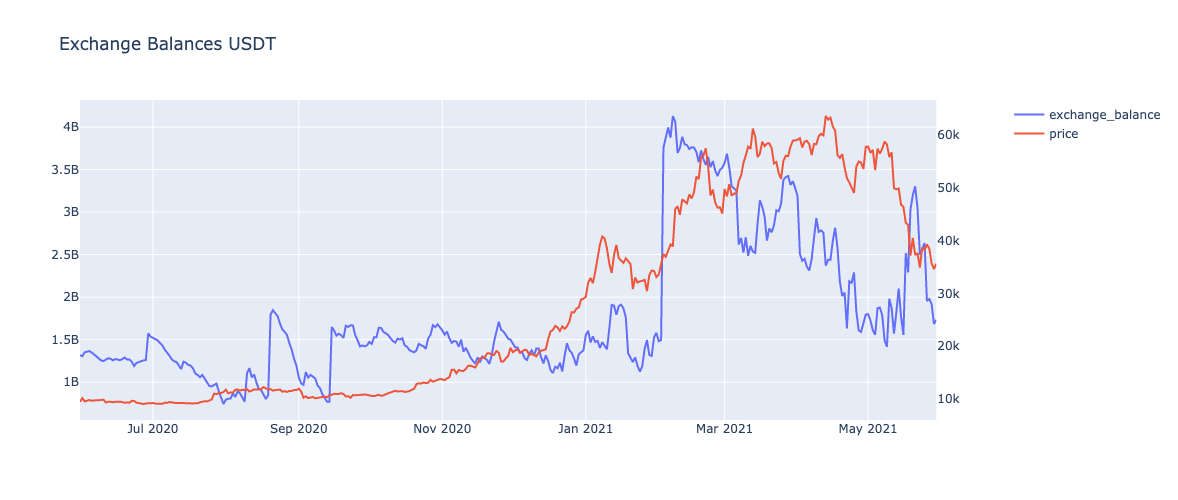

In [16]:
data = usdt_exch_balances.tail(365).copy()
data.loc[data.index,'price'] = btc_price.loc[data.index,'v']
data.rename(columns={'v':'exchange_balance'},inplace=True)
plot_two_axes(data,'exchange_balance','price','Exchange Balances USDT')

## BTC Exchange Inflow/Outflow (per exchange)

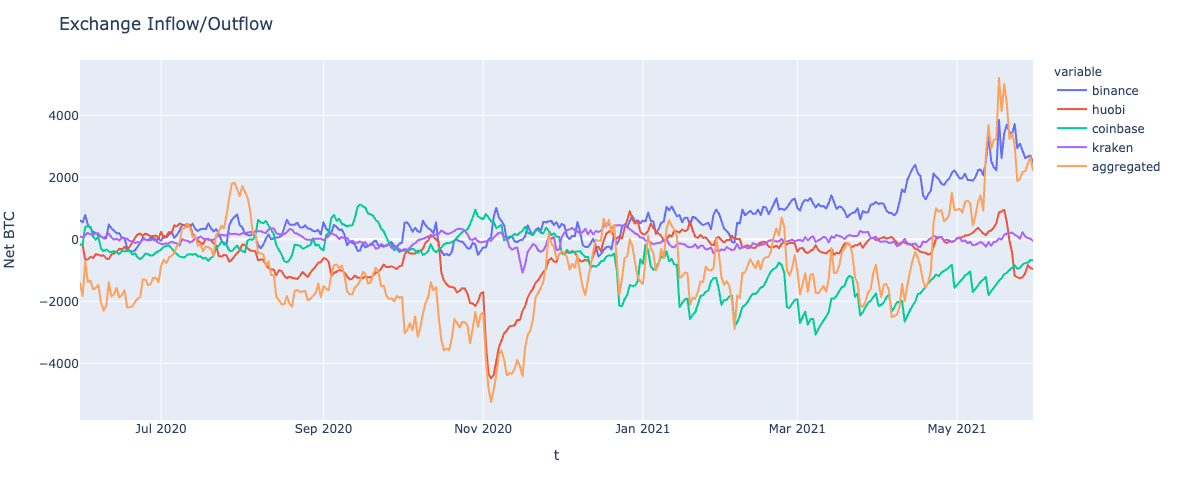

In [17]:
data = exch_flows.ewm(halflife=10).mean().tail(365)
fig = px.line(data, x=data.index, y=data.columns)
fig.update_layout(height=500)
fig.update_yaxes(title_text='Net BTC')
fig.update_layout(title_text=f"Exchange Inflow/Outflow")
fig.show()

In [18]:
# Are the binance coins going to collateral or are they being sold?

In [19]:
def get_exchange_flows(symbol):

    res = requests.get('https://api.glassnode.com/v1/metrics/transactions/transfers_volume_to_exchanges_sum', params={'a': symbol,'api_key': API_KEY})
    exch = pd.read_json(res.text, convert_dates=['t'])
    exch.set_index('t',inplace=True)

    res = requests.get('https://api.glassnode.com/v1/metrics/transactions/transfers_volume_from_exchanges_sum', params={'a': symbol,'api_key': API_KEY})
    from_exch = pd.read_json(res.text, convert_dates=['t'])
    from_exch.set_index('t',inplace=True)
    
    
    res = requests.get('https://api.glassnode.com/v1/metrics/market/price_usd', params={'a': symbol,'api_key': API_KEY})
    price = pd.read_json(res.text, convert_dates=['t'])
    price.set_index('t',inplace=True)

    exch['from'] = from_exch['v']
    exch.rename(columns={'v':'to'},inplace=True)

    exch['net'] = exch['to'] - exch['from']
    exch['price'] = price['v']

    exch['net_ma'] = exch['net'].ewm(halflife=10).mean()
    exch['symbol'] = symbol
    exch.index.name = symbol
    
    return exch

In [20]:
# Choices for Below:
# BTC, ETH, AAVE, ABT, AGI, AMPL, ANT, ARMOR, BADGER, BAL, BAND, BAT, BIX, BNT, BOND, BRD, BUSD, BZRX, CELR, CHSB, CND, 
# COMP, CREAM, CRO, CRV, CVC, CVP, DAI, DENT, DGTX, DGX, DHT, DMG, DODO, DRGN, ELF, ENG, ENJ, EURS, FET, FTT, FUN, GNO, 
# GUSD, HEGIC, HOT, HPT, HT, HUSD, KCS, KNC, LAMB, LBA, LDO, LEO, LINK, LOOM, LRC, MANA, MATIC, MCB, MCO, MFT, MIR, MKR, 
# MLN, MTA, MTL, MX, NEXO, NFTX, NMR, NPXS, Nsure, OCEAN, OKB, OMG, PAX, PAY, PERP, PICKLE, PNK, PNT, POLY, POWR, PPT, 
# QASH, QKC, QNT, RDN, REN, REP, RLC, ROOK, RSR, SAI, SAN, SNT, SNX, STAKE, STORJ, sUSD, SUSHI, TEL, TOP, UBT, UMA, UNI, 
# USDC, USDK, USDT, UTK, VERI, WaBi, WAX, WBTC, WETH, wNMX, WTC, YAM, YFI, ZRX

In [21]:
btc_exch = get_exchange_flows('BTC')
eth_exch = get_exchange_flows('ETH')
usdt_exch = get_exchange_flows('USDT')
usdt_exch['price'] = btc_exch['price']
AAVE_exch = get_exchange_flows('AAVE')
LINK_exch = get_exchange_flows('LINK')

In [22]:
all_exch_flows = pd.concat([btc_exch,eth_exch,usdt_exch,AAVE_exch.tail(180),LINK_exch.tail(180)])
all_exch_flows.index.name = 'date'

In [23]:
def plot_exch_flows(exch,num_days=365):
    
    symbol = exch.index.name
    data = exch.tail(num_days)

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Bar(x=data.index, y=data['net'], name="Inflow/Outflow"),
        secondary_y=False,
    )
    fig['layout']['yaxis2']['showgrid'] = False

    # Add traces
    fig.add_trace(
        go.Scatter(x=data.index, y=data['price'], name="Price"),
        secondary_y=True,
    )

    # Add figure title
    fig.update_layout(
        title_text=f"Exchange Inflow/Outflow ({symbol})",height=500
    )
    
    fig.show()

## Exchange Inflow/Outflow (BTC, ETH, USDT, AAVE, LINK)

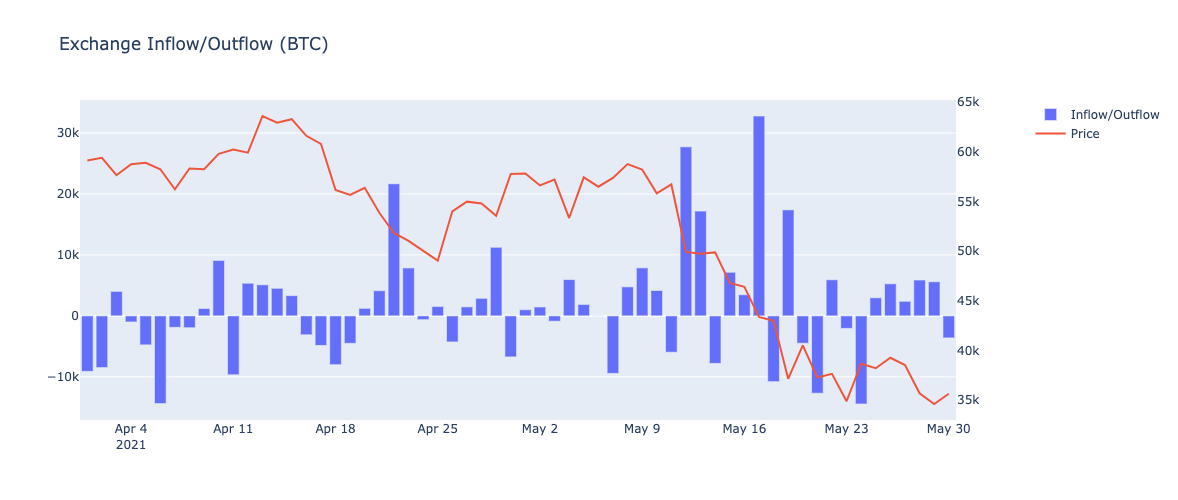

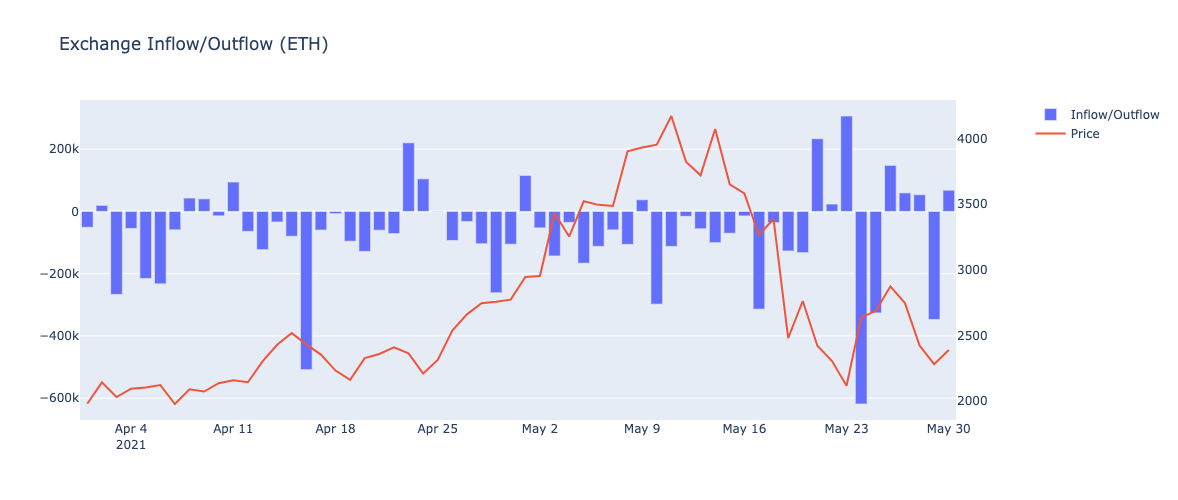

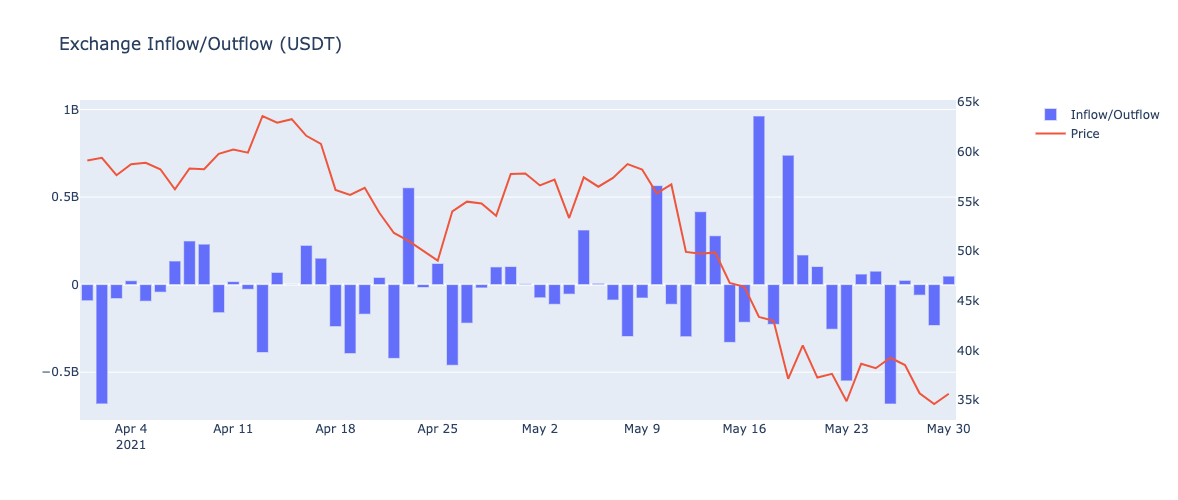

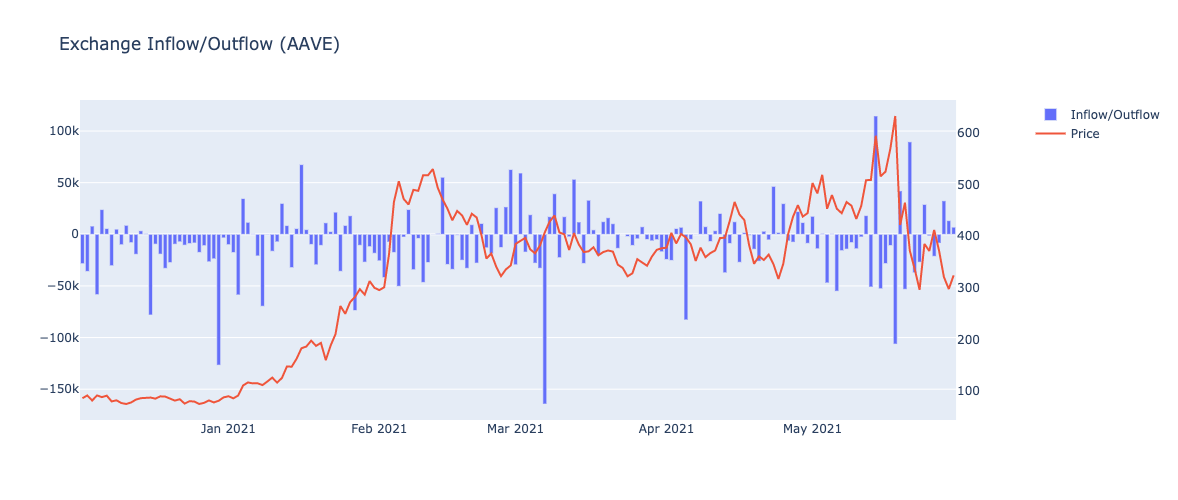

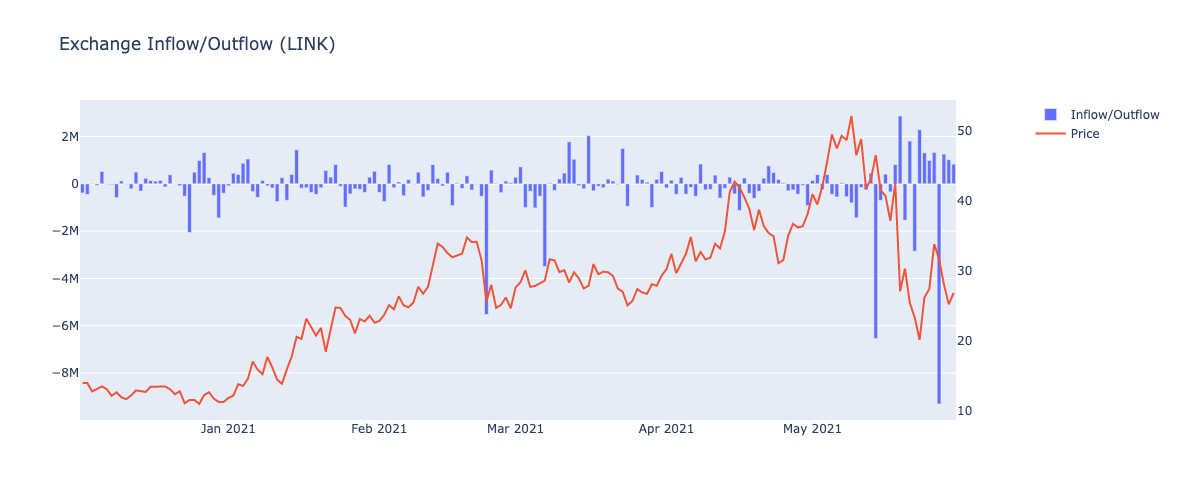

In [24]:
plot_exch_flows(btc_exch.tail(60))
plot_exch_flows(eth_exch.tail(60))
plot_exch_flows(usdt_exch.tail(60))
plot_exch_flows(AAVE_exch.tail(180))
plot_exch_flows(LINK_exch.tail(180))

In [25]:
res = requests.get('https://api.glassnode.com/v1/metrics/derivatives/futures_funding_rate_perpetual_all', params={'a': 'BTC','api_key': API_KEY})
perps = pd.read_json(res.text, convert_dates=['t'])
perps.set_index('t',inplace=True)
perps = perps['o'].apply(pd.Series)*100*100

## Stable Coin Supply Ratio
SSR  = Bitcoin Marketcap / Stablecoin Marketcap. \
Covers the following Stable coins: USDT, TUSD, USDC, PAX, GUSD, DAI, SAI, and BUSD.

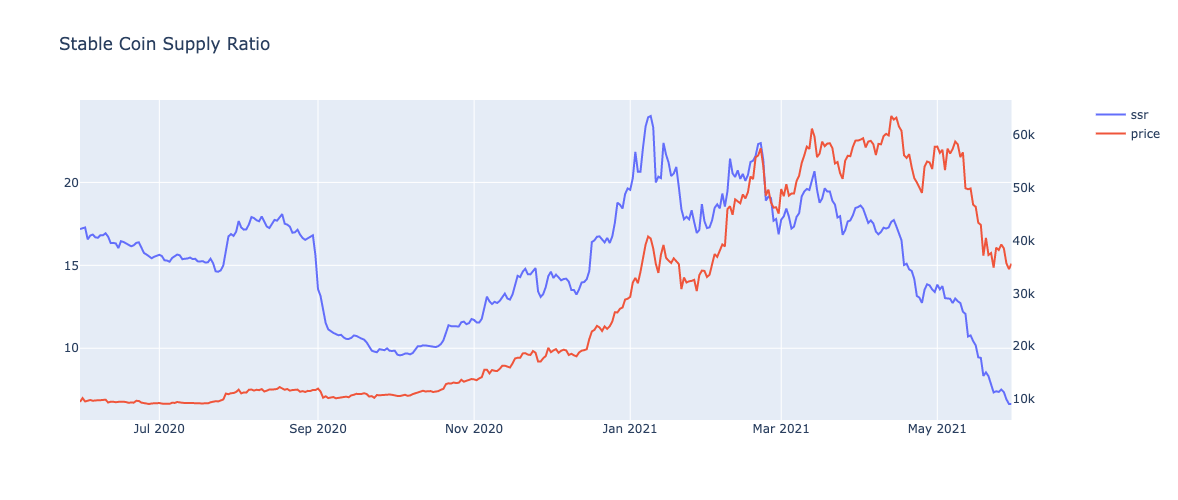

In [26]:
metric = 'indicators/ssr'
exchanges = None
btc_ssr = glassnode_request('BTC',metric,exchanges)

data = btc_ssr.tail(365).copy()
data.loc[data.index,'price'] = btc_price.loc[data.index,'v']
data.rename(columns={'v':'ssr'},inplace=True)
plot_two_axes(data,'ssr','price','Stable Coin Supply Ratio')

### Adjusted SOPR

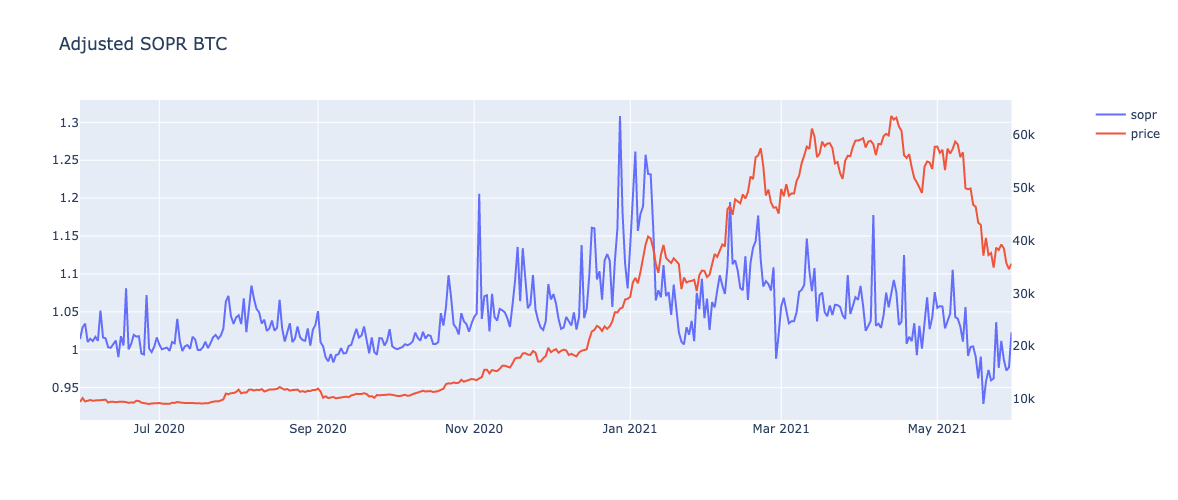

In [27]:
metric = 'indicators/sopr_adjusted'
exchanges = None
btc_sopr = glassnode_request('BTC',metric,exchanges)

data = btc_sopr.tail(365).copy()
data.loc[data.index,'price'] = btc_price.loc[data.index,'v']
data.rename(columns={'v':'sopr'},inplace=True)
plot_two_axes(data,'sopr','price','Adjusted SOPR BTC')

## BTC NVT

In [28]:
metric = 'indicators/nvts'
exchanges = None

btc_nvt = glassnode_request('BTC',metric,exchanges)
eth_nvt = glassnode_request('ETH',metric,exchanges)

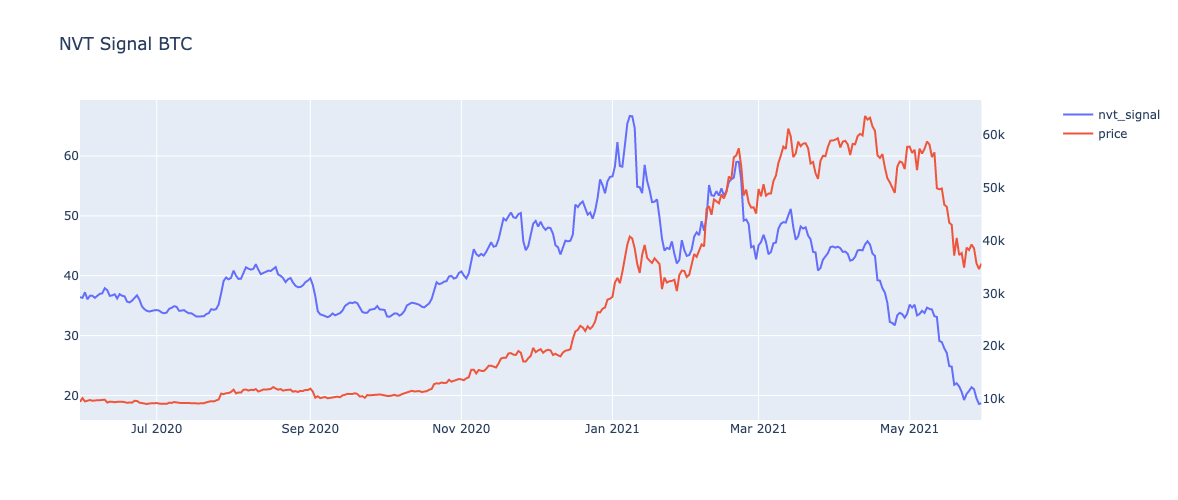

In [29]:
data = btc_nvt.tail(365).copy()
data.loc[data.index,'price'] = btc_price.loc[data.index,'v']
data.rename(columns={'v':'nvt_signal'},inplace=True)
plot_two_axes(data,'nvt_signal','price','NVT Signal BTC')

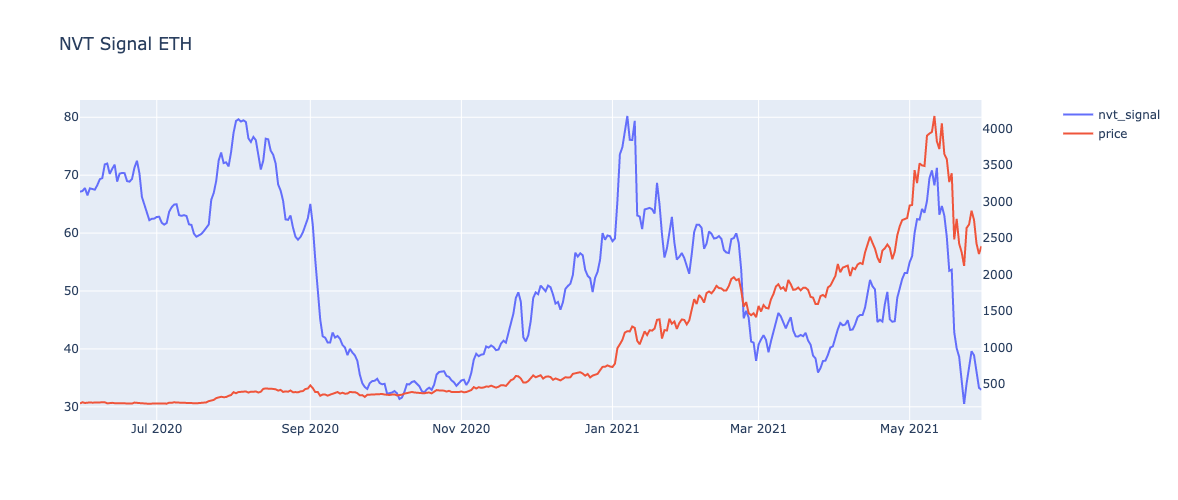

In [30]:
data = eth_nvt.tail(365).copy()
data.loc[data.index,'price'] = eth_price.loc[data.index,'v']
data.rename(columns={'v':'nvt_signal'},inplace=True)
plot_two_axes(data,'nvt_signal','price','NVT Signal ETH')

## Avg. Funding Rate

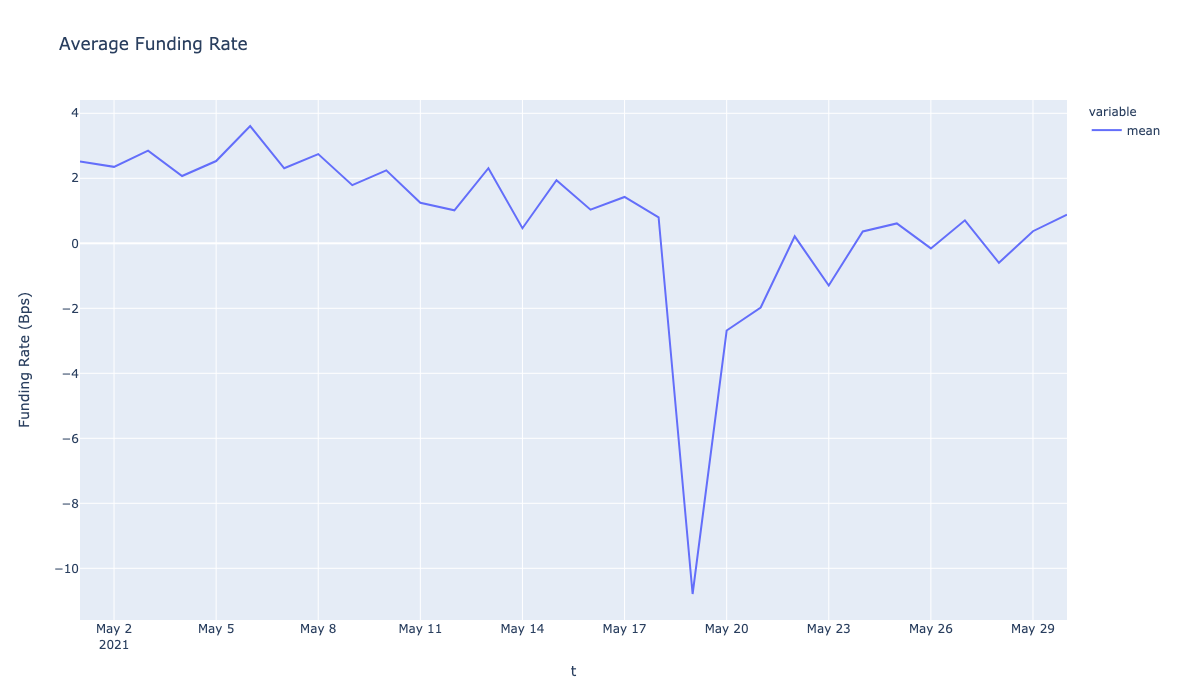

In [31]:
fig = px.line(perps['mean'],title='Average Funding Rate')
fig.update_yaxes(title_text='Funding Rate (Bps)')
# Add figure title
fig.update_layout(height=700)

## Avg. Funding Rate (per exchange)

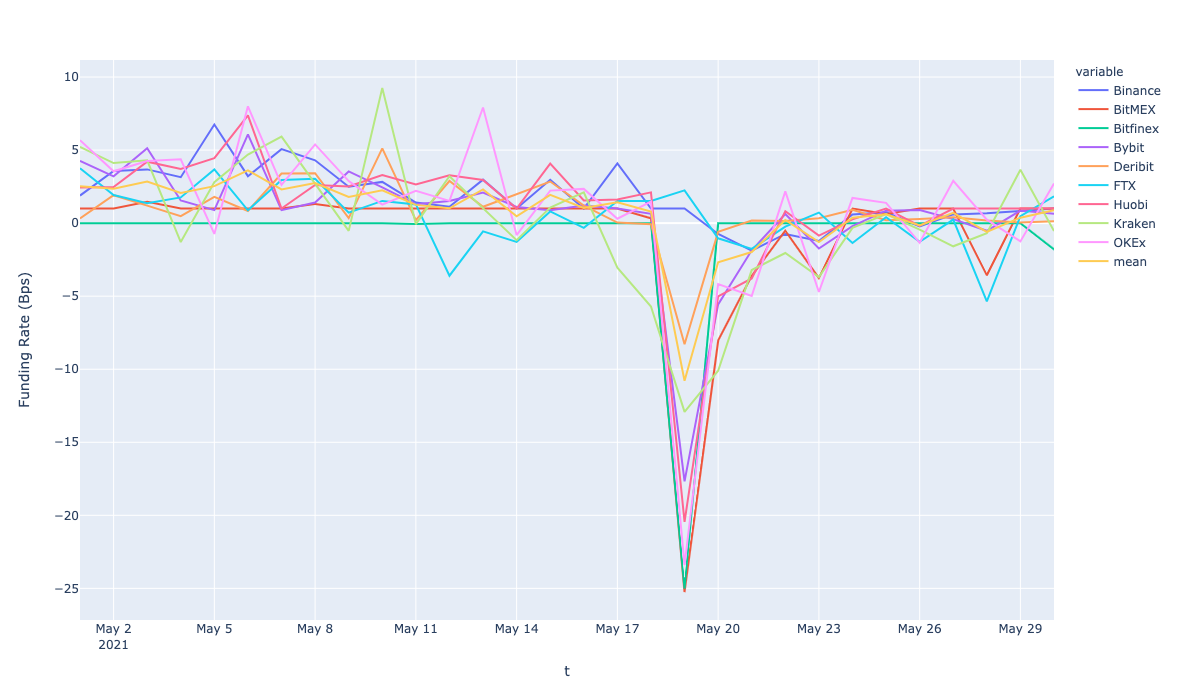

In [32]:
fig = px.line(perps, x=perps.index, y=perps.columns)
fig.update_layout(height=700)
fig.update_yaxes(title_text='Funding Rate (Bps)')
fig.show()

In [33]:
res = requests.get('https://api.glassnode.com/v1/metrics/derivatives/futures_open_interest_perpetual_sum_all', params={'a': 'BTC','api_key': API_KEY})
opint = pd.read_json(res.text, convert_dates=['t'])
opint.set_index('t',inplace=True)
opint = opint['o'].apply(pd.Series)

## Futures Open Interest (per exchange)

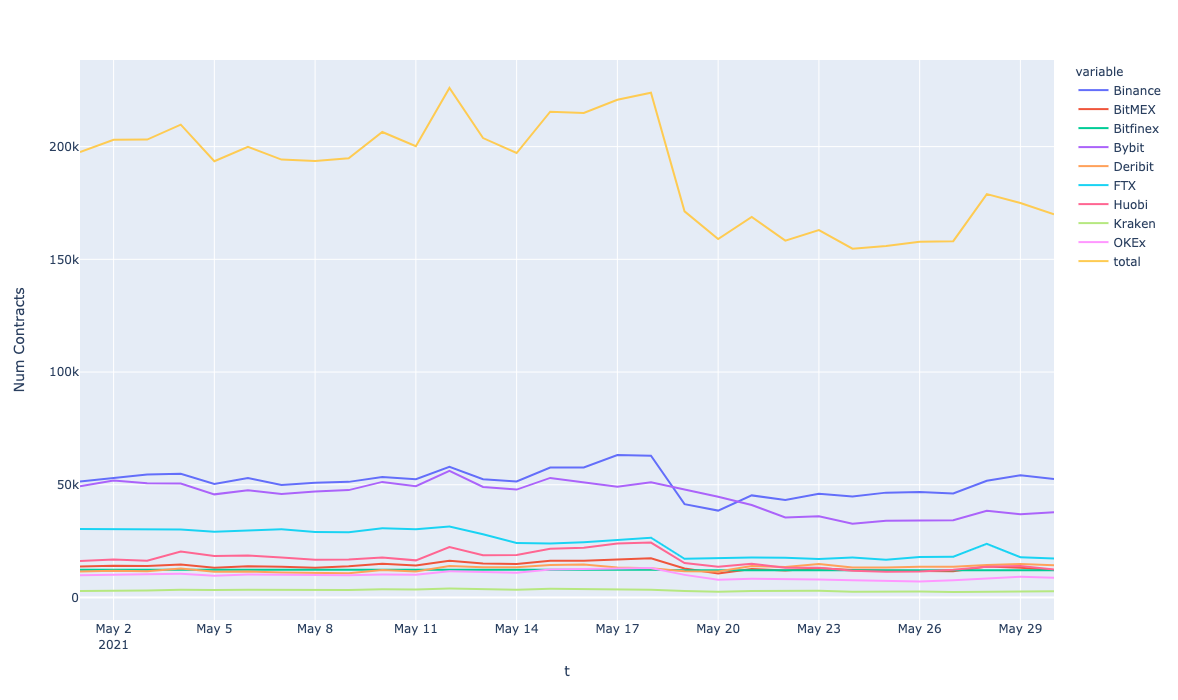

In [34]:
fig = px.line(opint, x=opint.index, y=opint.columns)
fig.update_layout(height=700)
fig.update_yaxes(title_text='Num Contracts')
fig.show()

## Future Premiums

In [35]:
import ccxt
import pandas as pd

exchange_id = 'binance'
exchange_class = getattr(ccxt, exchange_id)
exchange = exchange_class({
    'apiKey': '',
    'secret': '',
    'timeout': 30000,
    'enableRateLimit': True,
})

exchange.options = {'defaultType': 'delivery','adjustForTimeDifference': True,'defaultTimeInForce': 'GTC'}
markets = exchange.load_markets()  # Load the futures markets

f_exchange = exchange_class({'apiKey': '','secret': '','timeout': 30000, 'enableRateLimit': True,})
f_exchange.options = {'defaultType': 'futures','adjustForTimeDifference': True}

In [36]:
btc_markets = [m for m in markets if 'BTC' in m]
eth_markets = [m for m in markets if 'ETH' in m]

In [37]:
def get_mid(symbol):
    bidask = exchange.fetch_bids_asks(symbol, params={})[symbol]
    return 0.5*bidask['bid'] + 0.5*bidask['ask'] 

In [38]:
header = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
ccxt_btc = pd.DataFrame(exchange.fetch_ohlcv('BTC/USD','1d'),columns=header)

In [39]:
min90d = float(ccxt_btc['Low'].tail(90).min())
max90d = float(ccxt_btc['High'].tail(90).max())
last = float(ccxt_btc['Close'].tail(1).max())
print(f"Bitcoin is trading ${last:,.2f}, which is ${max90d-last:,.2f} below its 90day high and ${last-min90d:,.2f} above its 90day low.")

Bitcoin is trading $34,831.60, which is $30,198.30 below its 90day high and $7,587.60 above its 90day low.


In [40]:
def create_yield_curve(markets, exchange):
    spot = get_mid(markets[0])
    spot_name = markets[0]
    df = pd.DataFrame([], index = markets)
    df.index.name = exchange
    for m in markets:
        price = get_mid(m)
        df.loc[(m, 'price')] = price
        if m == spot_name:
            continue
        df.loc[(m, 'days_to_expiry')] = (datetime.strptime(m.split('_')[1],'%y%m%d') - datetime.utcnow()).days
        df.loc[(m, 'annualized_premium')] = np.log(price/spot)*365/df.loc[m, 'days_to_expiry'] * 100
    
    return df

In [41]:
create_yield_curve(btc_markets, 'binance')

price  days_to_expiry  annualized_premium
binance                                                    
BTC/USD        34836.55             NaN                 NaN
BTCUSD_210625  34809.75            24.0           -1.170438
BTCUSD_210924  35625.25           115.0            7.105608

In [42]:
create_yield_curve(eth_markets, 'binance')

price  days_to_expiry  annualized_premium
binance                                                    
ETH/USD        2313.915             NaN                 NaN
ETHUSD_210625  2315.985            24.0            1.215321
ETHUSD_210924  2368.595           115.0            7.382834

## Future Open Interest (Binance)

In [43]:
def binance_futures_oi(symbol):
    # Coin margined Futures
    
    params = {'pair':f'{symbol}USD','contractType':'ALL','period':'4h','limit':100}
    opint = pd.DataFrame(exchange.dapiData_get_openinteresthist(params))
    opint.index = pd.to_datetime(opint['timestamp'],unit='ms')
    opint['coin-m_OI'] = opint['sumOpenInterestValue'].astype(float)

    # USDT margined Futures
    params = {'symbol':f'{symbol}USDT','pair':f'{symbol}USDT','contractType':'ALL','period':'4h','limit':100}
    fopint = pd.DataFrame(f_exchange.fapiData_get_openinteresthist(params))
    fopint.index = pd.to_datetime(fopint['timestamp'],unit='ms')
    opint['usdt-m_OI'] = fopint['sumOpenInterest'].astype(float)
    
    fig = px.line(opint, x=opint.index, y=['coin-m_OI','usdt-m_OI'])
    fig.update_layout(title_text=f"Binance: {symbol} Open Interest", height=700)
    fig.update_yaxes(title_text=f'Num of {symbol}')
    fig.show()
    
    return opint

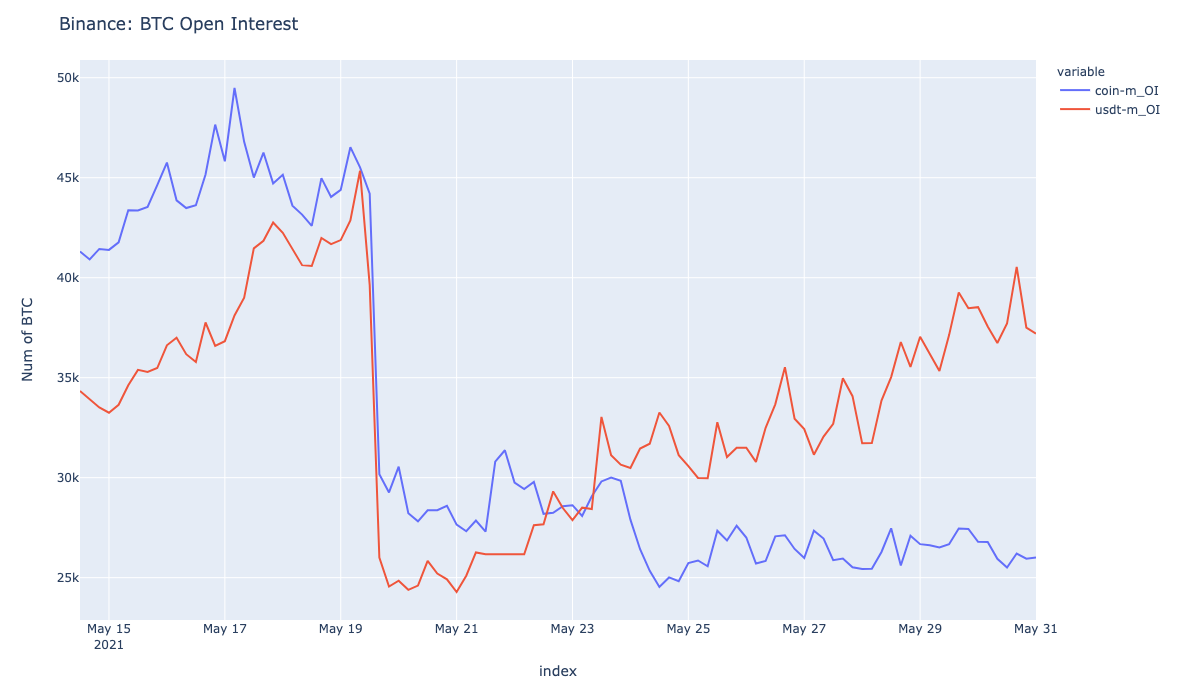

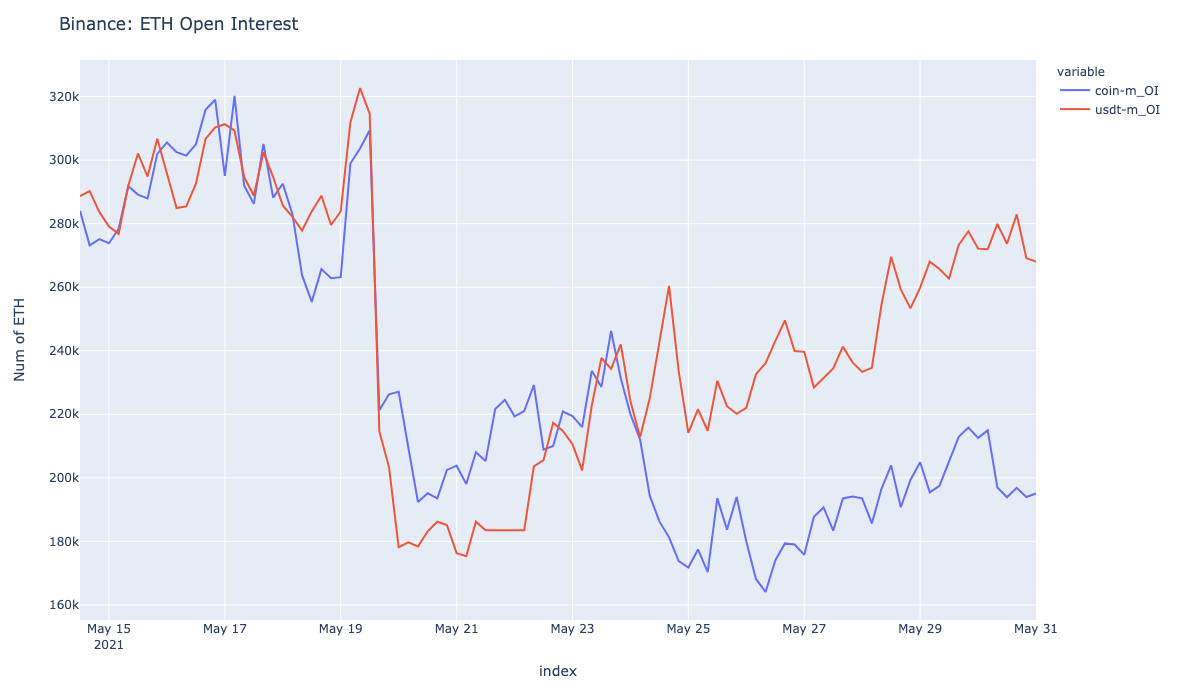

In [44]:
btc_opint = binance_futures_oi('BTC')
eth_opint = binance_futures_oi('ETH')

## Deribit BTC DVOL

In [45]:
import time
now_str = str(int(time.time())*1000)
# Get active options
req_url = 'https://deribit.com/api/v2/public/get_volatility_index_data'
params = {"currency": "BTC","resolution": "1D","start_timestamp": "1599373800000","end_timestamp": now_str}
r = requests.get(req_url,params)
data = r.json() 
vol_index = pd.DataFrame(data['result'])
vol_index = pd.DataFrame(vol_index.data.tolist(), index= vol_index.index,columns = ['time','open','high','low','close'])

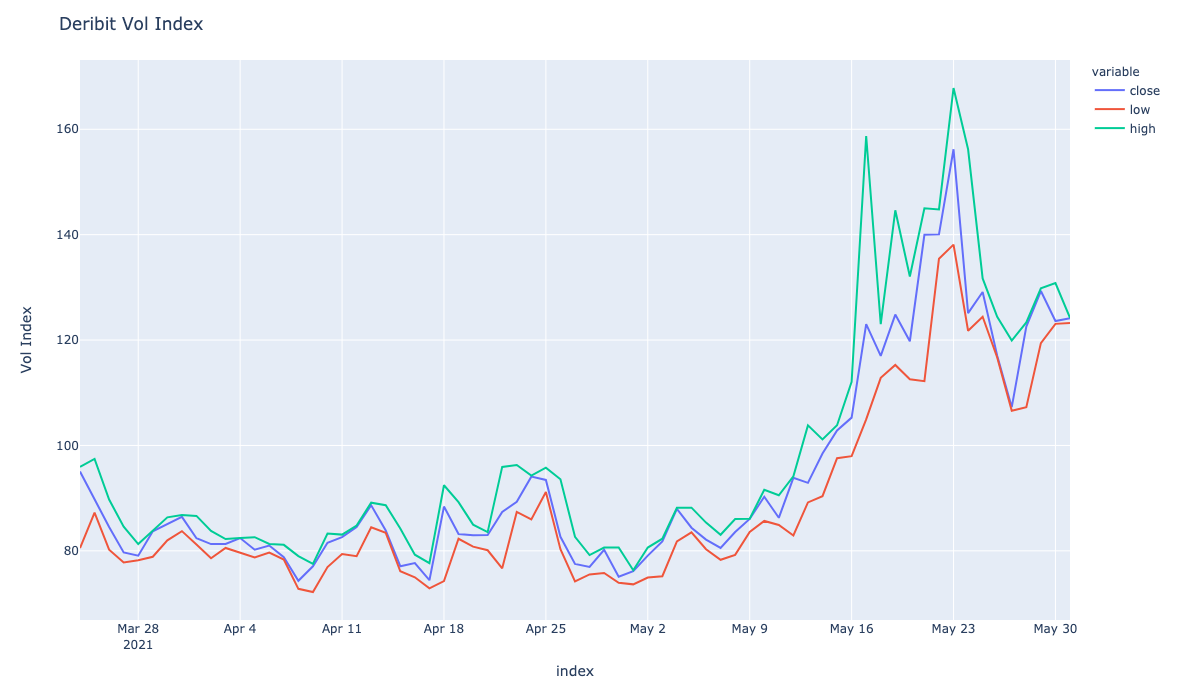

In [46]:
vol_index.index = pd.to_datetime(vol_index['time'],unit='ms')
fig = px.line(vol_index, x=vol_index.index, y=['close','low','high'])
fig.update_layout(height=700,title_text='Deribit Vol Index')
fig.update_yaxes(title_text='Vol Index')
fig.show()

# Traditional Finance

In [47]:
import yfinance as yf
today = pd.to_datetime("today").strftime("%Y-%m-%d")
data = yf.download("SPY ^TNX MGC=F NQ=F DX-Y.NYB BTC-USD", start="2020-01-01", end=today)
data = data['Close'].dropna()

[*********************100%***********************]  6 of 6 completed


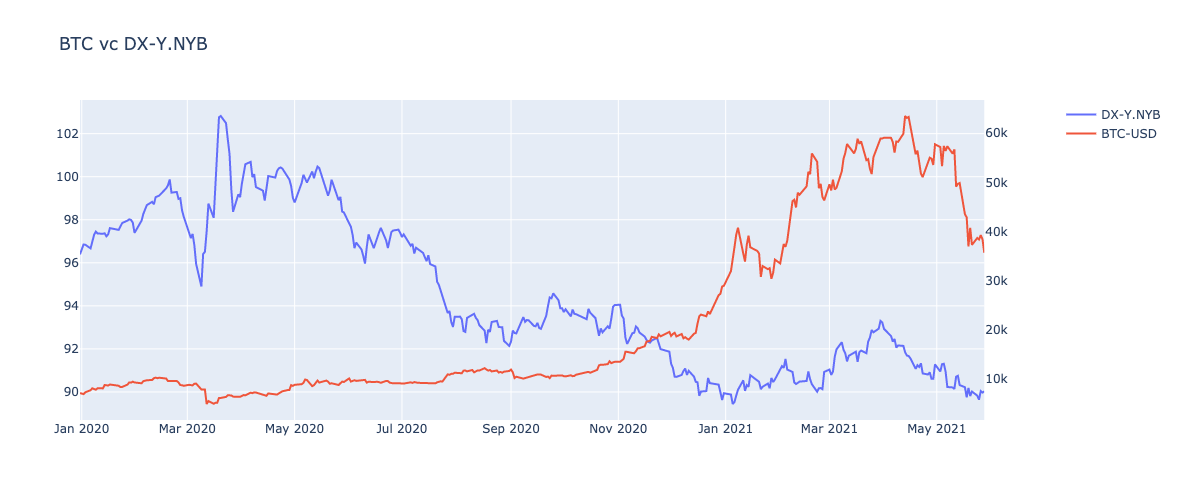

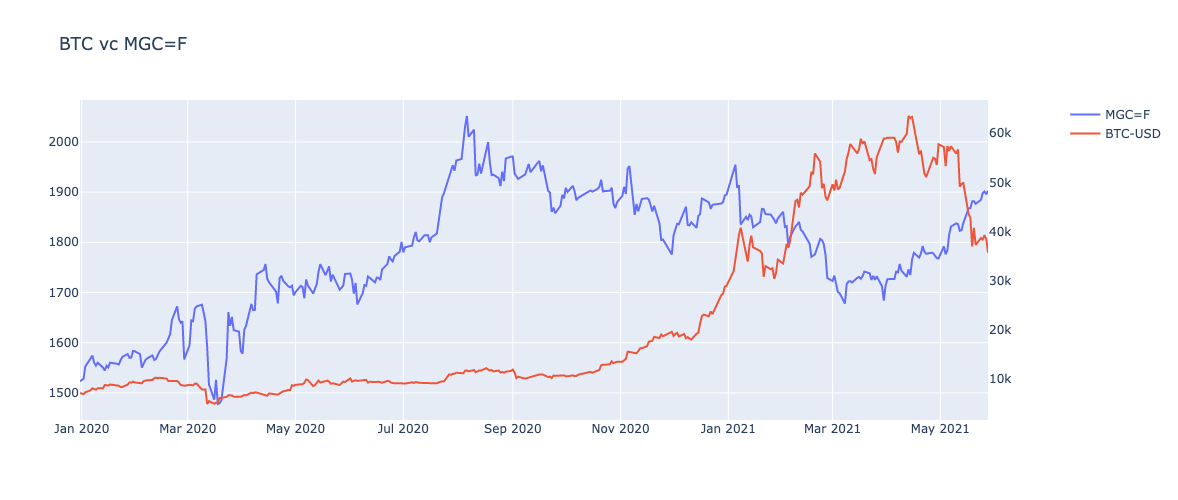

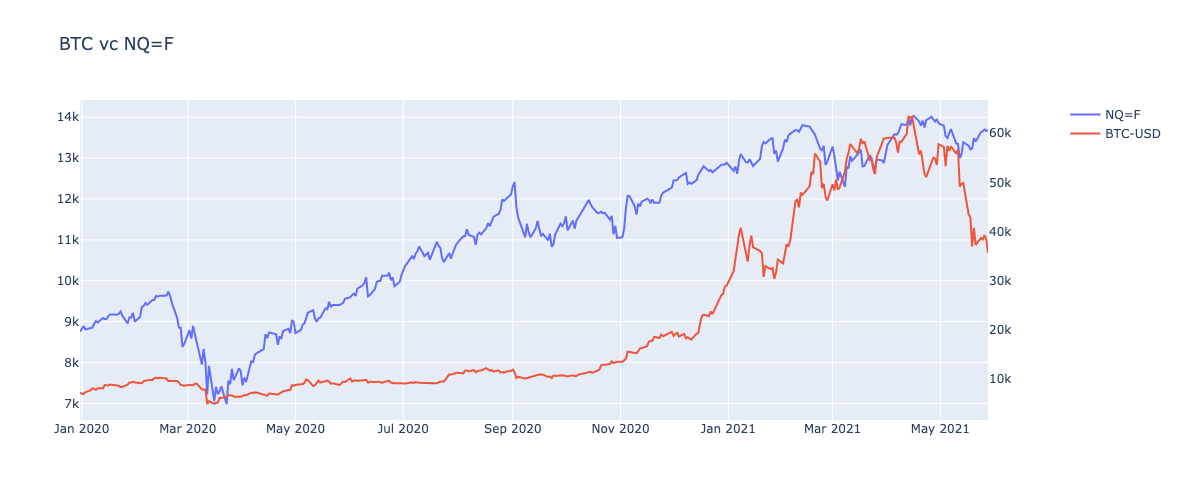

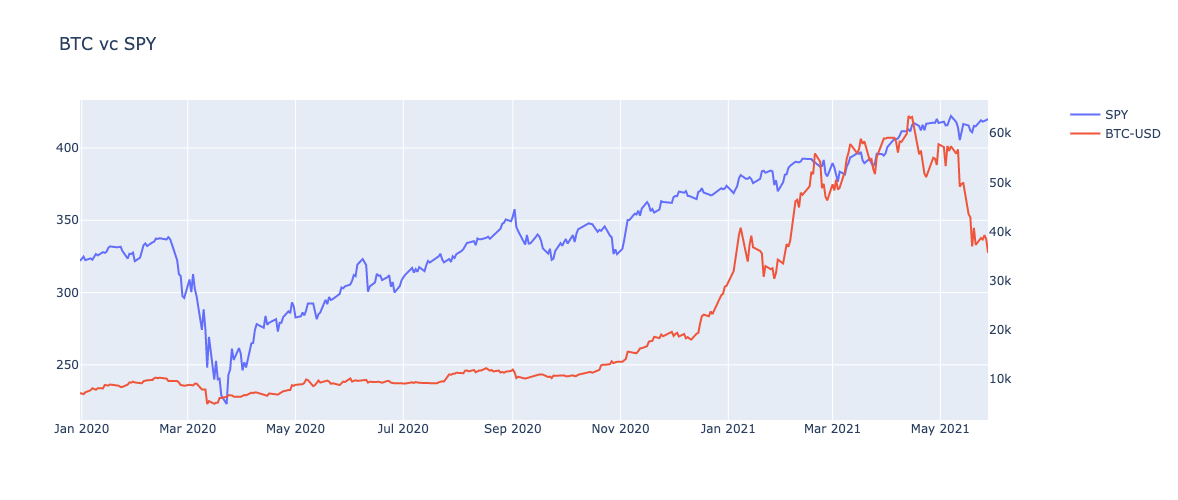

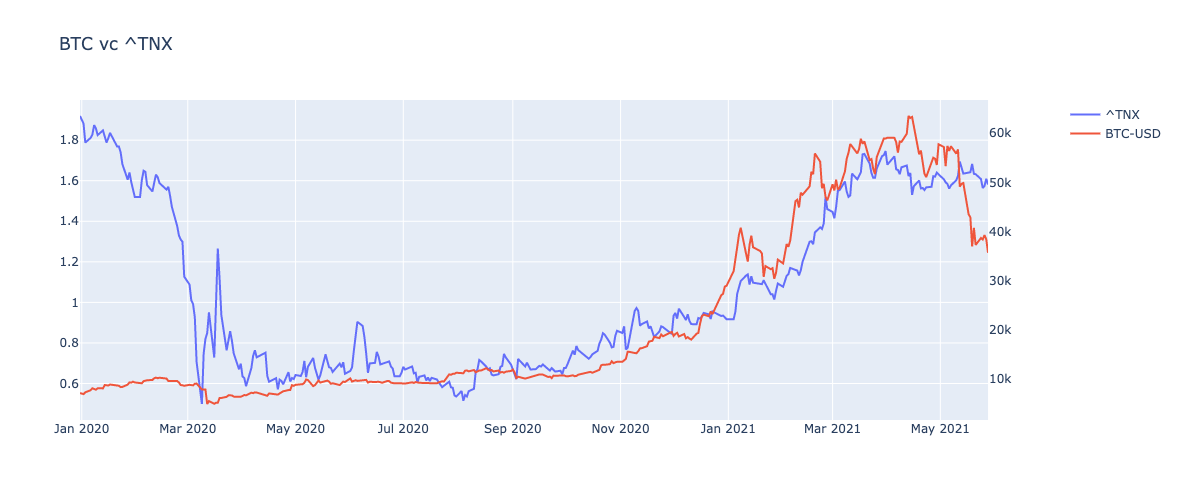

In [48]:
for col in data.columns:
    if col != 'BTC-USD':
        plot_two_axes(data,col,'BTC-USD',f'BTC vc {col}')

## Defi Rates

In [49]:
DEFI_API_KEY = "824d4b3157be6c75e79982be9f7ee822770f37d5aa6542fcb260ce492375"

r = requests.get(
        "https://data-api.defipulse.com/api/v1/defipulse/api/getLendingHistory?", 
        params={
            'api-key': DEFI_API_KEY
        }
)
print(r.status_code)
df = pd.DataFrame(json.loads(r.content.decode()))
df.timestamp = pd.to_numeric(df.timestamp, errors='coerce')
df = df.dropna()
df['date'] = pd.to_datetime(df.timestamp, unit='s').dt.date

def get_usdt(r, which="USDT"):
    try:
        return r[which]['USD']
    except:
        return 0

df['usdt'] = df.outstanding.apply(get_usdt, which="USDT")
df['total'] = df.outstanding.apply(get_usdt, which="total")

200


In [50]:
borrow_rates = df['borrow_rates'].apply(pd.Series)
borrow_rates.index = pd.to_datetime(df['timestamp'],unit='s')
lend_rates = df['lend_rates'].apply(pd.Series)
lend_rates.index = pd.to_datetime(df['timestamp'],unit='s')
outstanding = df['outstanding'].apply(pd.Series)
outstanding.index = pd.to_datetime(df['timestamp'],unit='s')

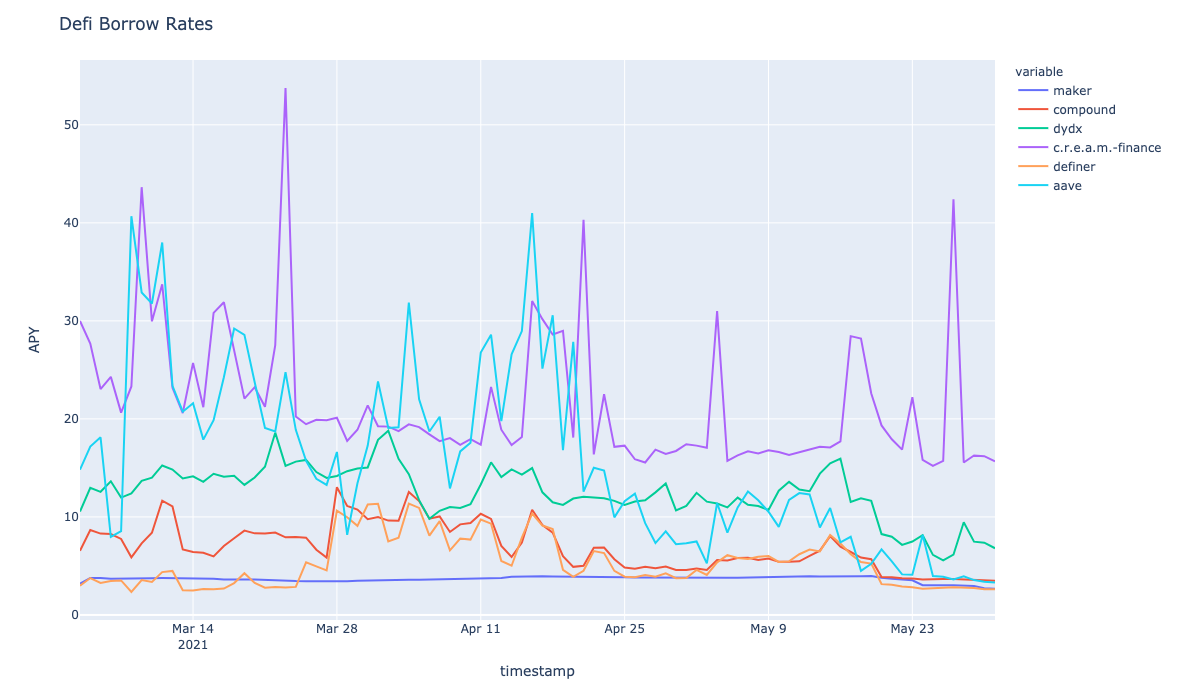

In [51]:
data = borrow_rates.head(90)
fig = px.line(data, x=data.index, y=data.columns)
fig.update_layout(height=700,title_text='Defi Borrow Rates')
fig.update_yaxes(title_text='APY')
fig.show()

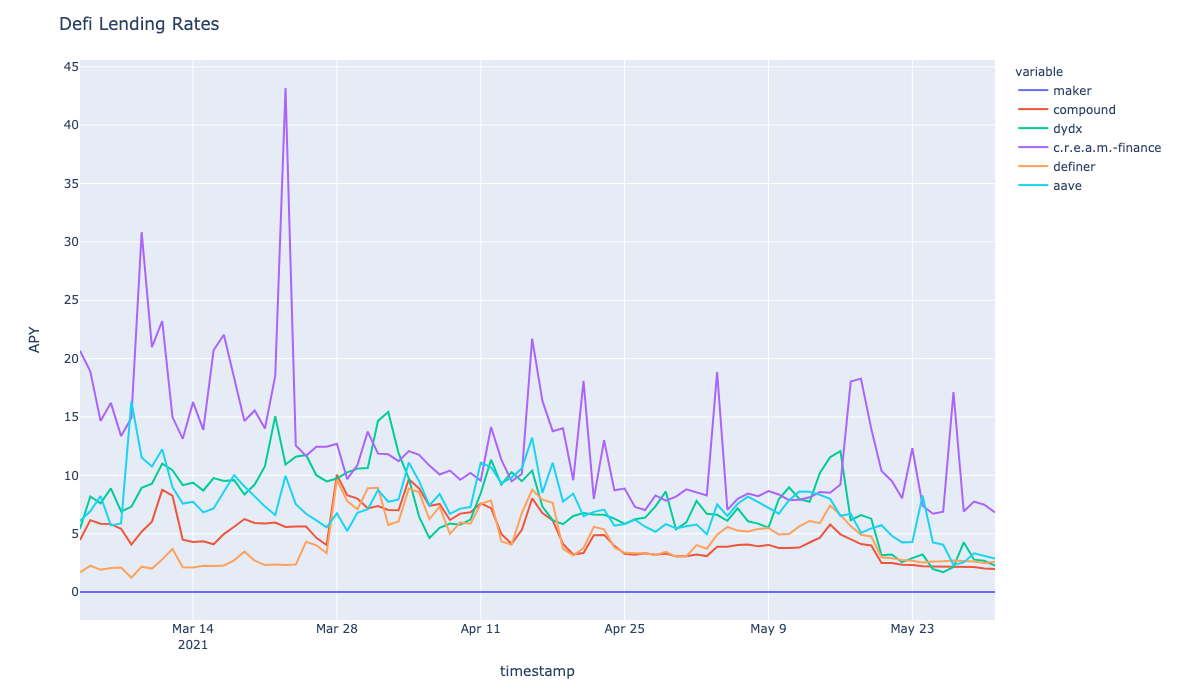

In [52]:
data = lend_rates.head(90)
fig = px.line(data, x=data.index, y=data.columns)
fig.update_layout(height=700,title_text='Defi Lending Rates')
fig.update_yaxes(title_text='APY')
fig.show()

In [53]:
tvl = pd.DataFrame(columns=outstanding.columns,index=outstanding.index)

for col in outstanding.columns:
    tvl[col] = outstanding[col].apply(pd.Series)['USD']


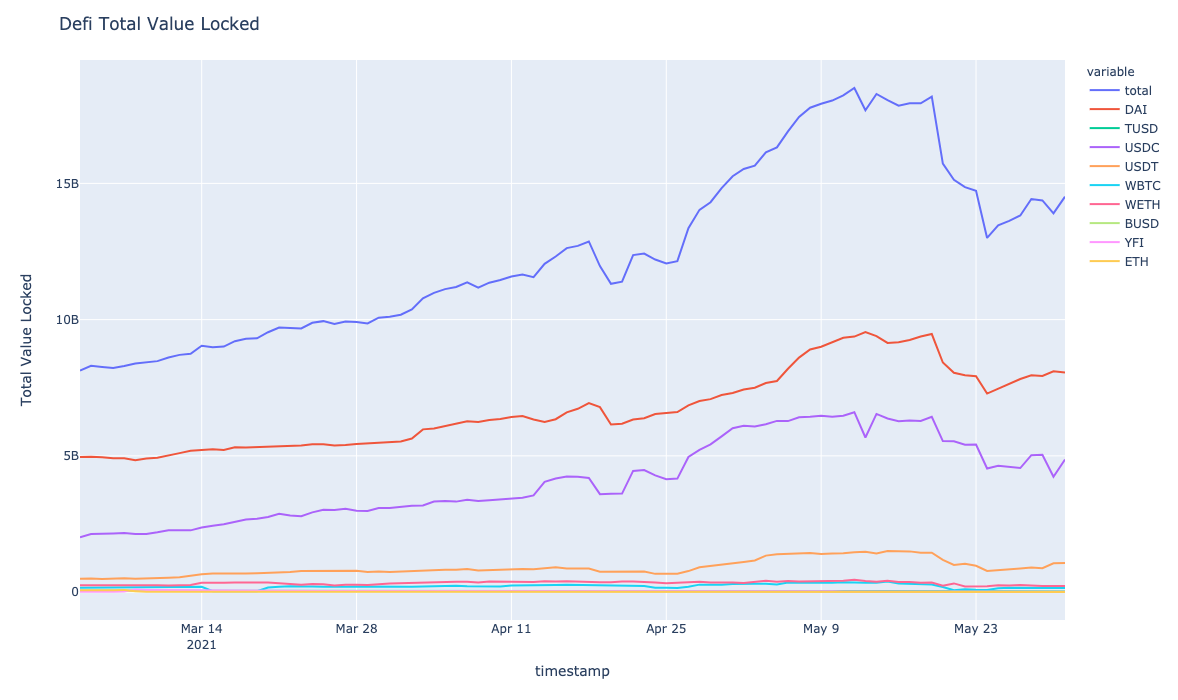

In [54]:
data = tvl.loc[:,tvl.mean()>10000000].head(90)
fig = px.line(data, x=data.index, y=data.columns)
fig.update_layout(height=700,title_text='Defi Total Value Locked')
fig.update_yaxes(title_text='Total Value Locked')
fig.show()

## Whales

In [55]:
whale_api_key = '9saZihVYIHkv3YdVwsqzlcKCqSIDPD0i'
now_str = str(int(time.time())-3000)
url = f"https://api.whale-alert.io/v1/transactions?api_key={whale_api_key}&min_value=1000000&start={now_str}"

In [56]:
import requests

In [57]:
resp = requests.get(url)

In [58]:
from nbconvert import HTMLExporter
import codecs
import nbformat

notebook_name = 'ShortTerm.ipynb'
output_file_name = 'output.html'

exporter = HTMLExporter()
output_notebook = nbformat.read(notebook_name, as_version=4)

output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(output_file_name, 'w', encoding='utf-8').write(output)